In [253]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
import json
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

import torch.utils.data
from sklearn.model_selection import train_test_split

import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [254]:
train_csv = pd.read_csv("Train.csv", keep_default_na=False)
test_csv = pd.read_csv("Test.csv", keep_default_na=False)

# train = train[0:30]
print(train_csv.dtypes)
#print(train_csv['traffic_volume'])

date_time               object
is_holiday              object
air_pollution_index      int64
humidity                 int64
wind_speed               int64
wind_direction           int64
visibility_in_miles      int64
dew_point                int64
temperature            float64
rain_p_h               float64
snow_p_h               float64
clouds_all               int64
weather_type            object
weather_description     object
traffic_volume           int64
dtype: object


In [255]:
test_csv.shape

(14454, 14)

In [256]:
train_csv.shape

(33750, 15)

In [257]:
def preprocess_data(dataset):
    #dataset['Power'] = dataset["Power"].replace("bhp", "", regex=True).replace("null", "", regex=True)
    #dataset['Power'] = pd.to_numeric(dataset["Power"].str.strip())
    #dataset['Engine'] = dataset["Engine"].replace("CC", "", regex=True)
    #dataset['Engine'] = pd.to_numeric(dataset["Engine"].str.strip())
    #dataset['Mileage'] = dataset["Mileage"].apply(convertKgtoL)
    #dataset['Mileage'] = pd.to_numeric(dataset["Mileage"])
    #dataset['New_Price'] = dataset["New_Price"].apply(convertKgtoL)
    #dataset['New_Price'] = pd.to_numeric(dataset["New_Price"])
    
    #dataset['Year_Old'] = dataset["Year"].apply(convertYearDiff)
    #dataset['Car_Brand'] = dataset["Name"].apply(convertToBrand)
    #dataset['Kilometers_Driven'] = dataset["Kilometers_Driven"]/dataset["Kilometers_Driven"].max()
    
    
    
    #dataset['Mileage'].fillna(dataset['Mileage'].mean(), inplace=True)
    #dataset['Power'].fillna(dataset['Power'].mean(), inplace=True)
    #dataset['Engine'].fillna(dataset['Engine'].mean(), inplace=True)
    #dataset['New_Price'].fillna(0.0, inplace=True)    
    
    dataset = dataset.replace('NaN', '')
    for col in list(dataset.columns):
        if dataset[col].dtype == np.float64 or dataset[col].dtype == np.int64:
            dataset[col] = pd.to_numeric(dataset[col])
            dataset[col] = dataset[col].mask(dataset[col]<=0, 0.00001)
            
    dataset = dataset.drop(['date_time'],axis=1)
    #dataset = dataset.drop(['Year'],axis=1)
    return dataset

In [258]:
train = preprocess_data(train_csv)
test = preprocess_data(test_csv)

display(train.head())
#train.columns

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,None,121,89,2.0,329.0,1,1,288.28,0.00001,0.00001,40.0,Clouds,scattered clouds,5545.0
1,None,178,67,3.0,330.0,1,1,289.36,0.00001,0.00001,75.0,Clouds,broken clouds,4516.0
2,None,113,66,3.0,329.0,2,2,289.58,0.00001,0.00001,90.0,Clouds,overcast clouds,4767.0
3,None,20,66,3.0,329.0,5,5,290.13,0.00001,0.00001,90.0,Clouds,overcast clouds,5026.0
4,None,281,65,3.0,329.0,7,7,291.14,0.00001,0.00001,75.0,Clouds,broken clouds,4918.0


In [259]:
train['traffic_volume'].describe()

count    33750.000000
mean      3240.118163
std       1991.487289
min          0.000010
25%       1165.250000
50%       3335.000000
75%       4926.000000
max       7280.000000
Name: traffic_volume, dtype: float64

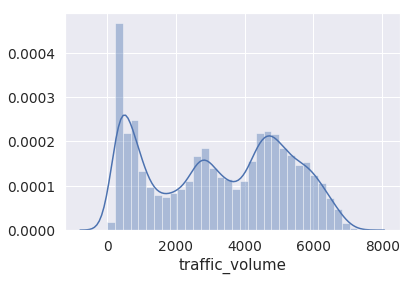

In [260]:
sns.distplot(train['traffic_volume']);

In [261]:
print("Skewness: %f" % train['traffic_volume'].skew())
print("Kurtosis: %f" % train['traffic_volume'].kurt())

Skewness: -0.071139
Kurtosis: -1.315953


In [262]:
train.dtypes

is_holiday              object
air_pollution_index      int64
humidity                 int64
wind_speed             float64
wind_direction         float64
visibility_in_miles      int64
dew_point                int64
temperature            float64
rain_p_h               float64
snow_p_h               float64
clouds_all             float64
weather_type            object
weather_description     object
traffic_volume         float64
dtype: object

In [263]:
combined_set = pd.concat([train, test], axis=0, ignore_index=True)

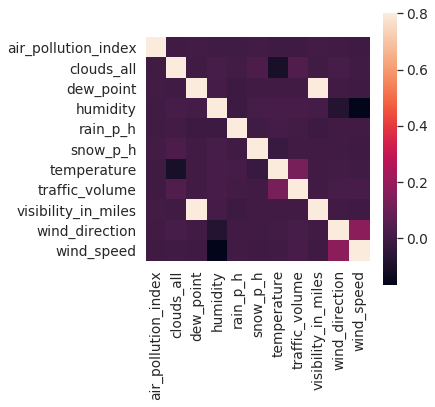

In [264]:
corcolm = ['SMA', 'WMA', 'MACD', 'MACD_Hist', 'FastK', 'RSI',
       'FatD', 'FatK', 'ADX', 'PPO', 'MOM', 'BOP',
       'ROC', 'ROCR', 'Aroon Down', 'Aroon Up', 
       'MFI', 'ULTOSC', 'DX', 'MINUS_DI', 'MINUS_DM',
       'MIDPOINT', 'MIDPRICE', 'ATR', 'Chaikin A/D',
       'ADOSC', 'LEAD SINE', 'SINE', 'TRENDMODE',
       'DCPERIOD', 'HT_DCPHASE', 'QUADRATURE', 'Company ', 'Price'];
#correlation matrix
#corrmat = combined_set[corcolm].corr()
corrmat = combined_set.corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=.8, square=True);


In [265]:
#combined_set = combined_set[corcolm]
#train = train[corcolm]

total = combined_set.isnull().sum().sort_values(ascending=False)
percent = (combined_set.isnull().sum()/combined_set.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
traffic_volume,14454,0.299851
wind_speed,0,0.000000
wind_direction,0,0.000000
weather_type,0,0.000000
weather_description,0,0.000000
visibility_in_miles,0,0.000000
temperature,0,0.000000
snow_p_h,0,0.000000
rain_p_h,0,0.000000
is_holiday,0,0.000000


In [266]:
combined_set = combined_set.interpolate(method ='linear', limit_direction ='both')

In [267]:
combined_set.isnull().sum().max() #just checking that there's no missing data missing...

0

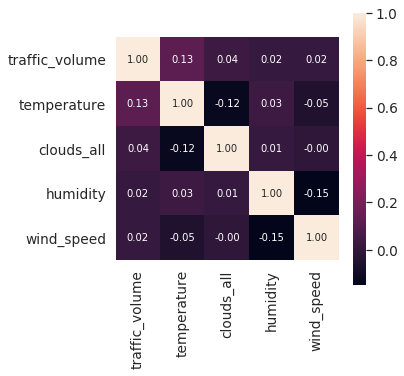

In [268]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'traffic_volume')['traffic_volume'].index
cm = np.corrcoef(combined_set[:33749][cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(5, 5))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [269]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(combined_set[:33749]['traffic_volume'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.62703477]
 [-1.62703477]
 [-1.62653263]
 [-1.62653263]
 [-1.62653263]
 [-1.62653263]
 [-1.62653263]
 [-1.62653263]
 [-1.62653263]
 [-1.62603049]]

outer range (high) of the distribution:
[[1.96329578]
 [1.96530435]
 [1.9828794 ]
 [1.98438583]
 [1.98438583]
 [1.99693943]
 [2.00899089]
 [2.01853163]
 [2.01853163]
 [2.02857451]]


In [270]:
col_train_num = list(cols)
col_train_num.append("is_holiday")
col_train_num.append("weather_type")
col_train_num.append("weather_description")

col_train_num_bias = list(cols)
col_train_num_bias.append("is_holiday")
col_train_num_bias.append("weather_type")
col_train_num_bias.append("weather_description")
col_train_num_bias.remove('traffic_volume')

print(col_train_num_bias)

#test = test[col_train_num_bias]
#train = train[col_train_num]

combined_set = combined_set[col_train_num]

#test = test.interpolate(method ='linear', limit_direction ='both') 
#scatter_matrix(train[col_train_num], figsize=(25, 25))
#plt.show()
#test.isnull().sum().max()

['temperature', 'clouds_all', 'humidity', 'wind_speed', 'is_holiday', 'weather_type', 'weather_description']


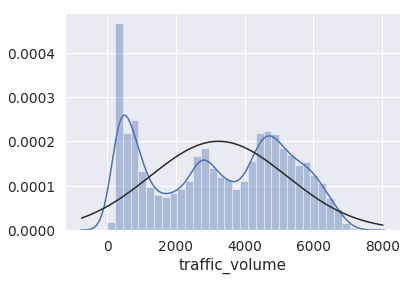

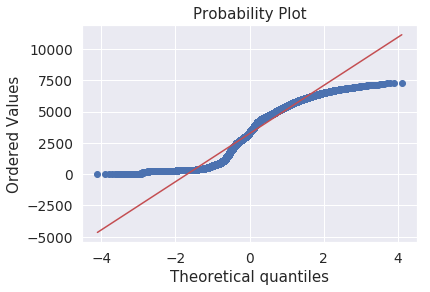

In [271]:
from scipy import stats
#histogram and normal probability plot
sns.distplot(combined_set[:33749]['traffic_volume'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(combined_set[:33749]['traffic_volume'], plot=plt)

traffic_volume
temperature
clouds_all
humidity
wind_speed
is_holiday
No graph for this is_holiday column
weather_type
No graph for this weather_type column
weather_description
No graph for this weather_description column


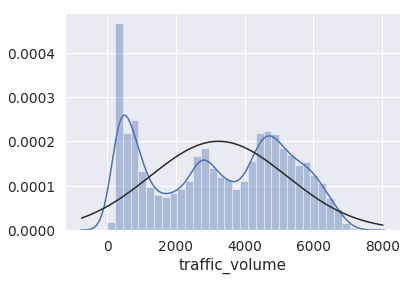

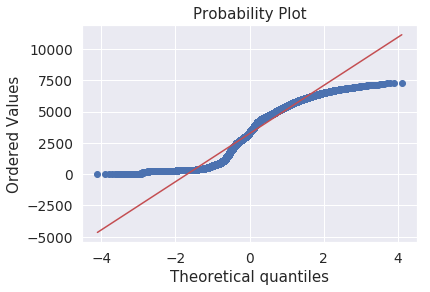

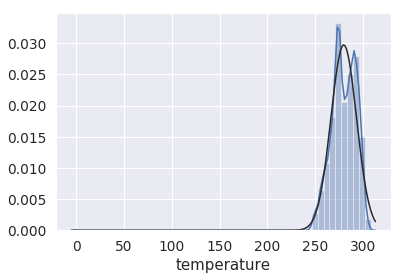

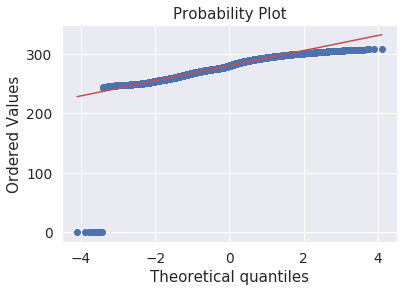

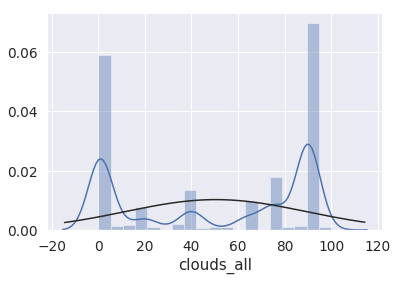

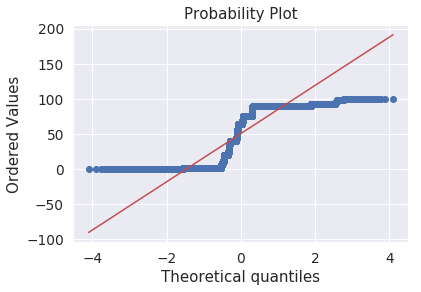

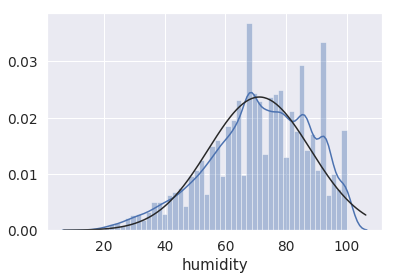

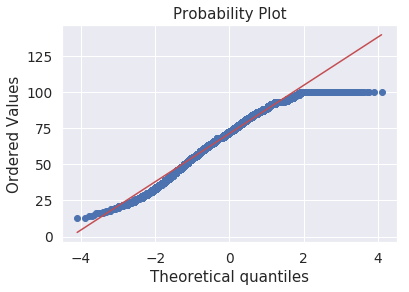

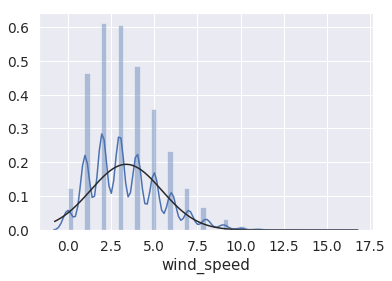

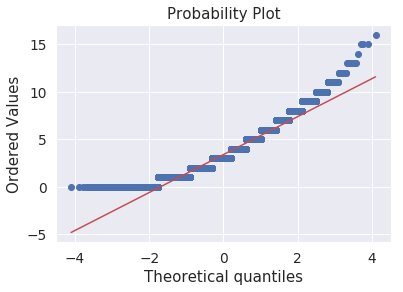

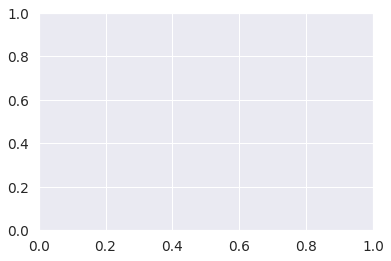

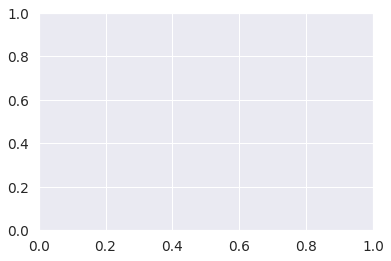

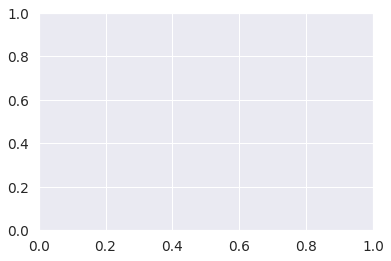

In [272]:
#train_numerical = train.select_dtypes(exclude=['object'])

for col in col_train_num:
    print(col)
    try:
        plt.figure()
        sns.distplot(combined_set[:33749][col], fit=stats.norm);
        fig = plt.figure()
        res = stats.probplot(combined_set[:33749][col], plot=plt)
    except TypeError:
        print("No graph for this {} column".format(col))
    #fig = plt.figure()
    #stats.probplot(train[col], plot=plt)

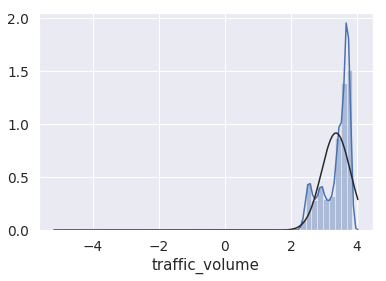

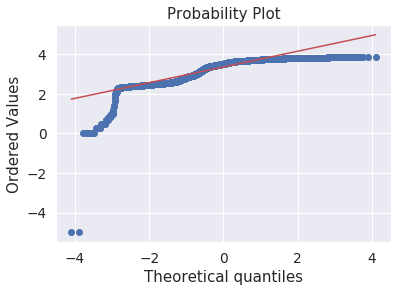

In [273]:
combined_set[:33749]['traffic_volume'] = np.log10(combined_set[:33749]['traffic_volume'])
sns.distplot(combined_set[:33749]['traffic_volume'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(combined_set[:33749]['traffic_volume'], plot=plt)

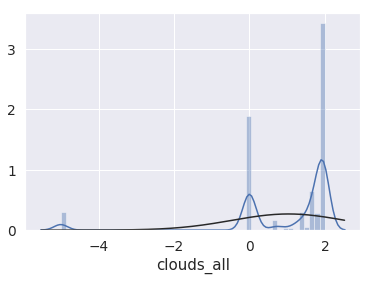

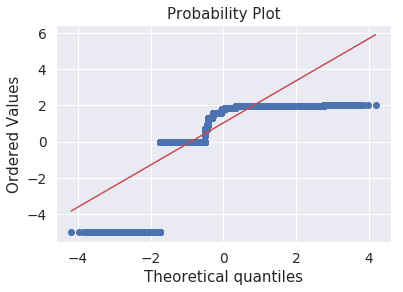

In [274]:
combined_set['clouds_all'] = np.log10(combined_set['clouds_all'])
sns.distplot(combined_set['clouds_all'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(combined_set['clouds_all'], plot=plt)

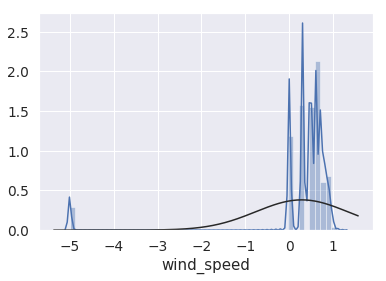

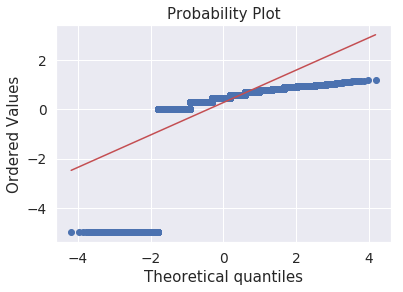

In [275]:
combined_set['wind_speed'] = np.log10(combined_set['wind_speed'])
sns.distplot(combined_set['wind_speed'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(combined_set['wind_speed'], plot=plt)

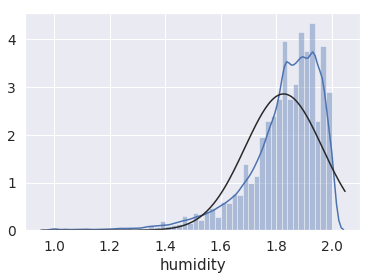

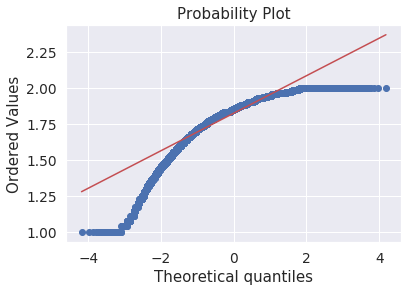

In [276]:
combined_set['humidity'] = np.log10(combined_set['humidity'])
sns.distplot(combined_set['humidity'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(combined_set['humidity'], plot=plt)

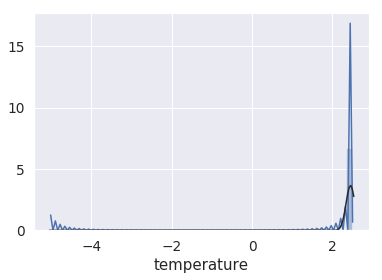

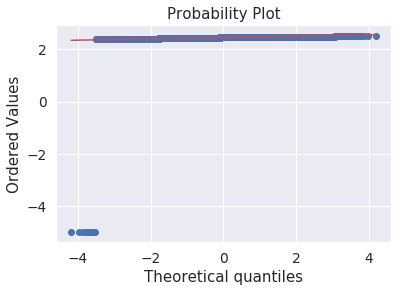

In [277]:
combined_set['temperature'] = np.log10(combined_set['temperature'])
sns.distplot(combined_set['temperature'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(combined_set['temperature'], plot=plt)

In [278]:
"""
train['PLUS_DI'] = np.log(train['PLUS_DI'])
test['PLUS_DI'] = np.log(test['PLUS_DI'])
sns.distplot(train['PLUS_DI'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['PLUS_DI'], plot=plt)
"""

"\ntrain['PLUS_DI'] = np.log(train['PLUS_DI'])\ntest['PLUS_DI'] = np.log(test['PLUS_DI'])\nsns.distplot(train['PLUS_DI'], fit=stats.norm);\nfig = plt.figure()\nres = stats.probplot(train['PLUS_DI'], plot=plt)\n"

In [279]:
"""
train.loc[train['WILLR']>0, 'WILLR'] = np.log(train[train['WILLR']>0]['WILLR'])
sns.distplot(train['WILLR'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['WILLR'], plot=plt)
"""

"\ntrain.loc[train['WILLR']>0, 'WILLR'] = np.log(train[train['WILLR']>0]['WILLR'])\nsns.distplot(train['WILLR'], fit=stats.norm);\nfig = plt.figure()\nres = stats.probplot(train['WILLR'], plot=plt)\n"

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


traffic_volume
temperature
clouds_all


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


humidity
wind_speed
is_holiday
No graph for this is_holiday column
weather_type
No graph for this weather_type column
weather_description
No graph for this weather_description column


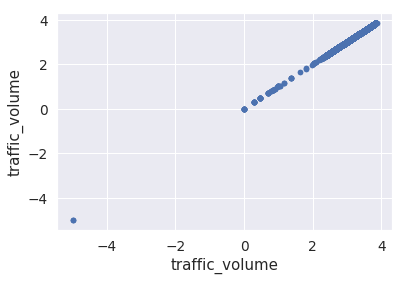

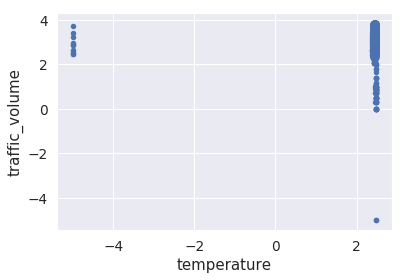

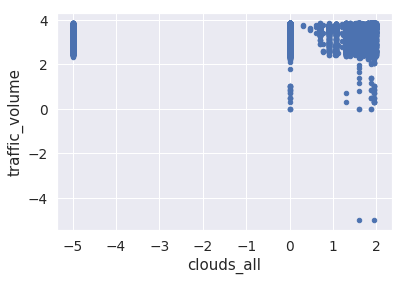

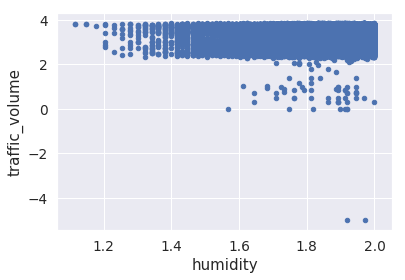

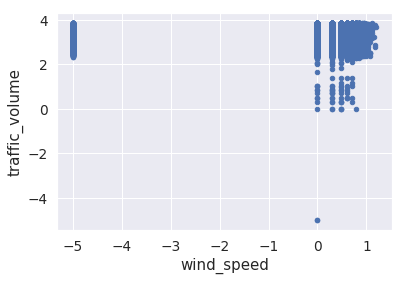

In [280]:
for col in col_train_num:
    print(col)
    try:
        data = pd.concat([combined_set[:33749]['traffic_volume'], combined_set[:33749][col]], axis=1)
        data.plot.scatter(x=col, y='traffic_volume');
    except ValueError:
        print("No graph for this {} column".format(col))

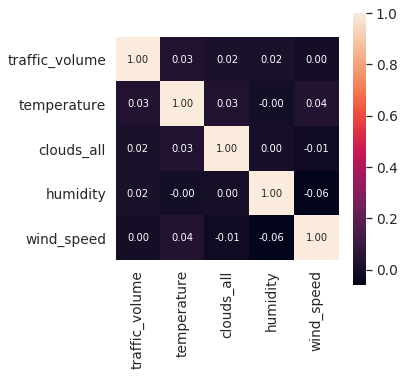

In [281]:
corrmat_next = combined_set[:33749].corr()
cols_next = corrmat_next.index
f, ax = plt.subplots(figsize=(5, 5))
hm = sns.heatmap(corrmat_next, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_next.values, xticklabels=cols_next.values)
plt.show()

In [282]:
combined_set = pd.get_dummies(combined_set)
display(combined_set.head())

,traffic_volume,temperature,clouds_all,humidity,wind_speed,is_holiday_Christmas Day,is_holiday_Columbus Day,is_holiday_Independence Day,is_holiday_Labor Day,is_holiday_Martin Luther King Jr Day,is_holiday_Memorial Day,is_holiday_New Years Day,is_holiday_None,is_holiday_State Fair,is_holiday_Thanksgiving Day,is_holiday_Veterans Day,is_holiday_Washingtons Birthday,weather_type_Clear,weather_type_Clouds,weather_type_Drizzle,weather_type_Fog,weather_type_Haze,weather_type_Mist,weather_type_Rain,weather_type_Smoke,weather_type_Snow,weather_type_Squall,weather_type_Thunderstorm,weather_description_SQUALLS,weather_description_Sky is Clear,weather_description_broken clouds,weather_description_drizzle,weather_description_few clouds,weather_description_fog,weather_description_freezing rain,weather_description_haze,weather_description_heavy intensity drizzle,weather_description_heavy intensity rain,weather_description_heavy snow,weather_description_light intensity drizzle,weather_description_light intensity shower rain,weather_description_light rain,weather_description_light rain and snow,weather_description_light shower snow,weather_description_light snow,weather_description_mist,weather_description_moderate rain,weather_description_overcast clouds,weather_description_proximity shower rain,weather_description_proximity thunderstorm,weather_description_proximity thunderstorm with drizzle,weather_description_proximity thunderstorm with rain,weather_description_scattered clouds,weather_description_shower drizzle,weather_description_shower snow,weather_description_sky is clear,weather_description_sleet,weather_description_smoke,weather_description_snow,weather_description_thunderstorm,weather_description_thunderstorm with drizzle,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_thunderstorm with rain,weather_description_very heavy rain
0,3.743902,2.459815,1.602060,1.949390,0.301030,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.654754,2.461438,1.875061,1.826075,0.477121,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.678245,2.461769,1.954243,1.819544,0.477121,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.701222,2.462593,1.954243,1.819544,0.477121,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.691789,2.464102,1.875061,1.812913,0.477121,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [283]:
print(combined_set.shape)

train = combined_set[:33749]
test = combined_set[33749:]
test = test.drop("traffic_volume",axis = 1)

col_train = list(train.columns)
col_train_bis = list(train.columns)
col_train_bis.remove("traffic_volume")

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('traffic_volume',axis = 1))

mat_y = np.array(train.traffic_volume).reshape((33749,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

# trimed_test.to_csv("output_final_3.csv")
train_set = pd.DataFrame(prepro.transform(train),columns = col_train)

# test = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

test_set  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

display(train_set.head())

(48204, 66)


,traffic_volume,temperature,clouds_all,humidity,wind_speed,is_holiday_Christmas Day,is_holiday_Columbus Day,is_holiday_Independence Day,is_holiday_Labor Day,is_holiday_Martin Luther King Jr Day,is_holiday_Memorial Day,is_holiday_New Years Day,is_holiday_None,is_holiday_State Fair,is_holiday_Thanksgiving Day,is_holiday_Veterans Day,is_holiday_Washingtons Birthday,weather_type_Clear,weather_type_Clouds,weather_type_Drizzle,weather_type_Fog,weather_type_Haze,weather_type_Mist,weather_type_Rain,weather_type_Smoke,weather_type_Snow,weather_type_Squall,weather_type_Thunderstorm,weather_description_SQUALLS,weather_description_Sky is Clear,weather_description_broken clouds,weather_description_drizzle,weather_description_few clouds,weather_description_fog,weather_description_freezing rain,weather_description_haze,weather_description_heavy intensity drizzle,weather_description_heavy intensity rain,weather_description_heavy snow,weather_description_light intensity drizzle,weather_description_light intensity shower rain,weather_description_light rain,weather_description_light rain and snow,weather_description_light shower snow,weather_description_light snow,weather_description_mist,weather_description_moderate rain,weather_description_overcast clouds,weather_description_proximity shower rain,weather_description_proximity thunderstorm,weather_description_proximity thunderstorm with drizzle,weather_description_proximity thunderstorm with rain,weather_description_scattered clouds,weather_description_shower drizzle,weather_description_shower snow,weather_description_sky is clear,weather_description_sleet,weather_description_smoke,weather_description_snow,weather_description_thunderstorm,weather_description_thunderstorm with drizzle,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_thunderstorm with rain,weather_description_very heavy rain
0,0.986659,0.996118,0.943151,0.942882,0.854437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.976600,0.996335,0.982152,0.803709,0.882820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.979250,0.996379,0.993463,0.796338,0.882820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.981843,0.996489,0.993463,0.796338,0.882820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.980779,0.996690,0.982152,0.788855,0.882820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [284]:
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "traffic_volume"

#FEATURES.remove('Price')

# Training set and Prediction set with the features to predict
training_set = train_set[col_train]
prediction_set = training_set.traffic_volume

# print(prediction_set)

X_train, X_val, y_train, y_val = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.4)

train_set_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))
val_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val.values))

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set_tensor,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size)
val_test_loader = torch.utils.data.DataLoader(val_set,batch_size=1, shuffle=False)

In [285]:
"""
train_numerical = train.select_dtypes(exclude=['object'])
train_numerical.fillna(0,inplace = True)
train_categoric = train.select_dtypes(include=['object'])
train_categoric.fillna('NONE',inplace = True)
train_new = train_numerical.merge(train_categoric, left_index = True, right_index = True)

test_numerical = test.select_dtypes(exclude=['object'])
test_numerical.fillna(0,inplace = True)
test_categoric = test.select_dtypes(include=['object'])
test_categoric.fillna('NONE',inplace = True)
test_new = test_numerical.merge(test_categoric, left_index = True, right_index = True) 

train.dtypes
"""

"\ntrain_numerical = train.select_dtypes(exclude=['object'])\ntrain_numerical.fillna(0,inplace = True)\ntrain_categoric = train.select_dtypes(include=['object'])\ntrain_categoric.fillna('NONE',inplace = True)\ntrain_new = train_numerical.merge(train_categoric, left_index = True, right_index = True)\n\ntest_numerical = test.select_dtypes(exclude=['object'])\ntest_numerical.fillna(0,inplace = True)\ntest_categoric = test.select_dtypes(include=['object'])\ntest_categoric.fillna('NONE',inplace = True)\ntest_new = test_numerical.merge(test_categoric, left_index = True, right_index = True) \n\ntrain.dtypes\n"

In [286]:
"""
# Removie the outliers
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_numerical)
y_noano = clf.predict(train_numerical)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_numerical.reset_index(drop = True, inplace = True)

train_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_categoric.reset_index(drop = True, inplace = True)

train_new = train_new.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_new.reset_index(drop = True, inplace = True)
display(train_new.head())
"""

"\n# Removie the outliers\nfrom sklearn.ensemble import IsolationForest\n\nclf = IsolationForest(max_samples = 100, random_state = 42)\nclf.fit(train_numerical)\ny_noano = clf.predict(train_numerical)\ny_noano = pd.DataFrame(y_noano, columns = ['Top'])\ny_noano[y_noano['Top'] == 1].index.values\n\ntrain_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]\ntrain_numerical.reset_index(drop = True, inplace = True)\n\ntrain_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]\ntrain_categoric.reset_index(drop = True, inplace = True)\n\ntrain_new = train_new.iloc[y_noano[y_noano['Top'] == 1].index.values]\ntrain_new.reset_index(drop = True, inplace = True)\ndisplay(train_new.head())\n"

In [287]:
"""
#col_train = list(train_new.columns)
col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)

col_train_cat = list(train_categoric.columns)

col_train_num_bis.remove('Price')

mat_train = np.matrix(train_numerical)
mat_test  = np.matrix(test_numerical)
mat_new = np.matrix(train_numerical.drop('Price',axis = 1))
mat_y = np.array(train_new.Price)

print(mat_y.shape)

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(5417,1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_num_bis)

def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

train_new[col_train_num] = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test_new[col_train_num_bis]  = test_num_scale

prediction_set = train_new.Price
print(prediction_set.shape)
combined = train_new.drop('Price',axis = 1).append(test_new)
combined.reset_index(inplace=True)
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, col_train_cat)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

train_new = combined[:5417]
test_new = combined[5417:]
"""

"\n#col_train = list(train_new.columns)\ncol_train_num = list(train_numerical.columns)\ncol_train_num_bis = list(train_numerical.columns)\n\ncol_train_cat = list(train_categoric.columns)\n\ncol_train_num_bis.remove('Price')\n\nmat_train = np.matrix(train_numerical)\nmat_test  = np.matrix(test_numerical)\nmat_new = np.matrix(train_numerical.drop('Price',axis = 1))\nmat_y = np.array(train_new.Price)\n\nprint(mat_y.shape)\n\nprepro_y = MinMaxScaler()\nprepro_y.fit(mat_y.reshape(5417,1))\n\nprepro = MinMaxScaler()\nprepro.fit(mat_train)\n\nprepro_test = MinMaxScaler()\nprepro_test.fit(mat_new)\n\ntrain_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)\ntest_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_num_bis)\n\ndef oneHotEncode(df,colNames):\n    for col in colNames:\n        if( df[col].dtype == np.dtype('object')):\n            dummies = pd.get_dummies(df[col],prefix=col)\n            df = pd.concat([df,dummies],axis=1)\n\n  

In [288]:
"""
# Train and Test 
X_train, X_val, y_train, y_val = train_test_split(train_new, prediction_set, test_size=0.33, random_state=42)
train_set_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))
val_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val.values))

batch_size = 1
train_loader = torch.utils.data.DataLoader(train_set_tensor,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size)
"""

'\n# Train and Test \nX_train, X_val, y_train, y_val = train_test_split(train_new, prediction_set, test_size=0.33, random_state=42)\ntrain_set_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))\nval_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val.values))\n\nbatch_size = 1\ntrain_loader = torch.utils.data.DataLoader(train_set_tensor,batch_size=batch_size, shuffle=True)\nval_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size)\n'

In [289]:
# Hyperparameters
# batch_no = len(X_train) // batch_size  #batches
# cols=X_train.shape[1] #Number of columns in input matrix

# Sequence Length
#sequence_length = 6  # of words in a sequence 892110
# Batch Size
# batch_size = 128
# train_loader = batch_data(int_text, sequence_length, batch_size)
# Number of Epochs
num_epochs = 1000
# Learning Rate
learning_rate = 0.0002
# Model parameters
# Input size
input_size = X_train.shape[1]
# Output size
output_size = 1
# Embedding Dimension
#embedding_dim = 128
# Hidden Dimension
hidden_dim = 128
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 50

In [290]:
import torch.nn as nn

class DNNClassifier(nn.Module):
    """
    This is the simple DNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, hidden_dim, input_size, output_size, dropout=0.5):
        """
        Initialize the model by settingg up the various layers.
        """
        super(DNNClassifier, self).__init__()

        self.sig = nn.Sigmoid()        
        # self.word_dict = None
        
        self.fc1 = nn.Linear(input_size, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        #self.fc3 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc4 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(p=0.5)
        self.init_weights()
        
    def init_weights(m):
        initrange = 0.08
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            # get the number of the inputs
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.normal_(0.0, y)
            m.bias.data.fill_(0)
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        out = self.out(x)
        return out

In [291]:
from torch.autograd import Variable

def forward_back_prop(rnn, optimizer, criterion, inputs, labels, clip=9):

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    hidden = {}
    # hidden = tuple([each.data for each in hidden_dim])
    
    rnn.zero_grad()
    optimizer.zero_grad()
    #print(inputs)
    try:
        # get the output from the model
        # output, hidden = rnn(inputs, hidden)
        output = rnn.forward(inputs)
        #output = rnn(inputs.unsqueeze(0))
        output = output.squeeze()
        #print(output)
    except RuntimeError:
        raise
    #print(labels)
    loss = criterion(output, labels)
    loss.backward()
    
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    # nn.utils.clip_grad_norm_(rnn.parameters(),  clip)
   
    optimizer.step()

    return loss.item()

In [292]:
def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    val_batch_losses = []
    valid_loss_min = np.Inf
    
    rnn.train()
    
    previousLoss = np.Inf
    minLoss = np.Inf

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        # hidden = rnn.init_hidden(batch_size)
        # print("epoch ",epoch_i)
        rnn.train()
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            # batch_last = batch_i
            # n_batches = len(train_loader.dataset) // batch_size
            loss = forward_back_prop(rnn, optimizer, criterion, inputs, labels, clip=5)
            #print(loss)
            # record loss
            batch_losses.append(loss)
            
        rnn.eval()
        for batch_i, (inputs, labels) in enumerate(val_loader, 1):
            # batch_last = batch_i
            # n_batches = len(val_loader.dataset) // batch_size
            if(train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            # if(batch_i > n_batches):
                # break
            try:
                output = rnn.forward(inputs)
                output = output.squeeze()
            except RuntimeError:
                raise
            # print(labels)
            loss = criterion(output, labels)

            val_batch_losses.append(loss.item())

        # printing loss stats
        if epoch_i%show_every_n_batches == 0:
            average_loss = np.average(batch_losses)
            val_average_loss = np.average(val_batch_losses)
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch_i, average_loss, val_average_loss))

            ## TODO: save the model if validation loss has decreased
            # save model if validation loss has decreased
            if val_average_loss < valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                val_average_loss))
                with open('save/trained_rnn_new', 'wb') as pickle_file:
                    torch.save(rnn, pickle_file)
                valid_loss_min = val_average_loss

            batch_losses = []
            val_batch_losses = []
            
    return rnn

In [293]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

In [294]:
# create model and move to gpu if available
# rnn = RNN(input_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.25)
# rnn.apply(weight_init)
#rnn = LSTMClassifier(embedding_dim, hidden_dim, input_size, n_layers, output_size)
rnn = DNNClassifier(hidden_dim, input_size, output_size)

#rnn = torch.load("save/trained_rnn_new")

if train_on_gpu:
    rnn.cuda()

decay_rate = learning_rate / num_epochs

# print(decay_rate)
# defining loss and optimization functions for training
#optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9, weight_decay=decay_rate)

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
#rnn = torch.load("trained_rnn_new")

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
# helper.save_model('./save/trained_rnn', trained_rnn)
print('Model Trained and Saved')

Training for 1000 epoch(s)...
Epoch: 50 	Training Loss: 0.006327 	Validation Loss: 0.002752
Validation loss decreased (inf --> 0.002752).  Saving model ...
Epoch: 100 	Training Loss: 0.002594 	Validation Loss: 0.002496
Validation loss decreased (0.002752 --> 0.002496).  Saving model ...
Epoch: 150 	Training Loss: 0.002486 	Validation Loss: 0.002430
Validation loss decreased (0.002496 --> 0.002430).  Saving model ...
Epoch: 200 	Training Loss: 0.002456 	Validation Loss: 0.002405
Validation loss decreased (0.002430 --> 0.002405).  Saving model ...
Epoch: 250 	Training Loss: 0.002442 	Validation Loss: 0.002395
Validation loss decreased (0.002405 --> 0.002395).  Saving model ...
Epoch: 300 	Training Loss: 0.002435 	Validation Loss: 0.002390
Validation loss decreased (0.002395 --> 0.002390).  Saving model ...
Epoch: 350 	Training Loss: 0.002431 	Validation Loss: 0.002387
Validation loss decreased (0.002390 --> 0.002387).  Saving model ...
Epoch: 400 	Training Loss: 0.002428 	Validation Loss

In [295]:
def predict(model, inputs):

    if(train_on_gpu):
        inputs = inputs.cuda()
    
    try:
        output = model.forward(inputs)
        output = output.squeeze()
        #print(output)
    except RuntimeError:
        raise
    
    # prediction = np.array(output).argmax(0)
    # p = F.softmax(output, dim=1).data
    # p = F.sigmoid(output)
    # p = F.logsigmoid(output)
    p = output.cpu().detach().numpy().flatten()
    #print(p[0])
    # prediction = np.argmax(p)
    # print(prediction)
    return p[0]

In [296]:
model_rnn = torch.load("save/trained_rnn_new")
model_rnn.eval()
display(X_train.head())

,temperature,clouds_all,humidity,wind_speed,is_holiday_Christmas Day,is_holiday_Columbus Day,is_holiday_Independence Day,is_holiday_Labor Day,is_holiday_Martin Luther King Jr Day,is_holiday_Memorial Day,is_holiday_New Years Day,is_holiday_None,is_holiday_State Fair,is_holiday_Thanksgiving Day,is_holiday_Veterans Day,is_holiday_Washingtons Birthday,weather_type_Clear,weather_type_Clouds,weather_type_Drizzle,weather_type_Fog,weather_type_Haze,weather_type_Mist,weather_type_Rain,weather_type_Smoke,weather_type_Snow,weather_type_Squall,weather_type_Thunderstorm,weather_description_SQUALLS,weather_description_Sky is Clear,weather_description_broken clouds,weather_description_drizzle,weather_description_few clouds,weather_description_fog,weather_description_freezing rain,weather_description_haze,weather_description_heavy intensity drizzle,weather_description_heavy intensity rain,weather_description_heavy snow,weather_description_light intensity drizzle,weather_description_light intensity shower rain,weather_description_light rain,weather_description_light rain and snow,weather_description_light shower snow,weather_description_light snow,weather_description_mist,weather_description_moderate rain,weather_description_overcast clouds,weather_description_proximity shower rain,weather_description_proximity thunderstorm,weather_description_proximity thunderstorm with drizzle,weather_description_proximity thunderstorm with rain,weather_description_scattered clouds,weather_description_shower drizzle,weather_description_shower snow,weather_description_sky is clear,weather_description_sleet,weather_description_smoke,weather_description_snow,weather_description_thunderstorm,weather_description_thunderstorm with drizzle,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_thunderstorm with rain,weather_description_very heavy rain
11483,0.989673,0.972311,0.697981,0.902958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5318,0.992896,0.993463,0.825178,0.931341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25177,0.997536,0.993463,0.908672,0.805916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6111,0.995856,0.993463,0.788855,0.902958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9250,0.995611,0.994827,0.706974,0.918578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [297]:
display(test_set.head())

,temperature,clouds_all,humidity,wind_speed,is_holiday_Christmas Day,is_holiday_Columbus Day,is_holiday_Independence Day,is_holiday_Labor Day,is_holiday_Martin Luther King Jr Day,is_holiday_Memorial Day,is_holiday_New Years Day,is_holiday_None,is_holiday_State Fair,is_holiday_Thanksgiving Day,is_holiday_Veterans Day,is_holiday_Washingtons Birthday,weather_type_Clear,weather_type_Clouds,weather_type_Drizzle,weather_type_Fog,weather_type_Haze,weather_type_Mist,weather_type_Rain,weather_type_Smoke,weather_type_Snow,weather_type_Squall,weather_type_Thunderstorm,weather_description_SQUALLS,weather_description_Sky is Clear,weather_description_broken clouds,weather_description_drizzle,weather_description_few clouds,weather_description_fog,weather_description_freezing rain,weather_description_haze,weather_description_heavy intensity drizzle,weather_description_heavy intensity rain,weather_description_heavy snow,weather_description_light intensity drizzle,weather_description_light intensity shower rain,weather_description_light rain,weather_description_light rain and snow,weather_description_light shower snow,weather_description_light snow,weather_description_mist,weather_description_moderate rain,weather_description_overcast clouds,weather_description_proximity shower rain,weather_description_proximity thunderstorm,weather_description_proximity thunderstorm with drizzle,weather_description_proximity thunderstorm with rain,weather_description_scattered clouds,weather_description_shower drizzle,weather_description_shower snow,weather_description_sky is clear,weather_description_sleet,weather_description_smoke,weather_description_snow,weather_description_thunderstorm,weather_description_thunderstorm with drizzle,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_thunderstorm with rain,weather_description_very heavy rain
0,0.995606,0.993463,0.773537,0.805916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.995485,0.993463,0.773537,0.805916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.995485,0.993463,0.773537,0.805916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.995485,0.993463,0.715806,0.805916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.995411,0.993463,0.715806,0.805916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [298]:
Val_outputs = []
Val_tagrets = []

for batch_i, (inputs, labels) in enumerate(val_test_loader, 1):
    # n_batches = len(val_loader.dataset) // batch_size
    try:
        labels = labels.cpu().detach().numpy().flatten()
        valoutput = predict(model_rnn, torch.FloatTensor(row))
        Val_outputs.append(valoutput)
        Val_tagrets.append(labels[0])
    except RuntimeError:
        raise

print(Val_outputs[:10])
print(Val_tagrets[:10])

r2_score(Val_tagrets, Val_outputs)

[0.9427439, 0.9427439, 0.9427439, 0.9427439, 0.9427439, 0.9427439, 0.9427439, 0.9427439, 0.9427439, 0.9427439]
[0.9218634, 0.9812644, 0.97889954, 0.94425374, 0.91365266, 0.87719154, 0.9759881, 0.87160474, 0.8961736, 0.9757347]


-0.00045921915316182726

In [299]:
Val_outputs = []
print(train[:500].shape)

pred_training_set = train_set[col_train][:500]
pred_training_set = pred_training_set.drop('traffic_volume',axis = 1)

for row in pred_training_set.values:
    valoutput = predict(model_rnn, torch.FloatTensor(row))
    Val_outputs.append(valoutput)

print(Val_outputs[:10])
print(y_val.values[:10])

s_out = pd.Series(prepro_y.inverse_transform(np.array(Val_outputs).reshape(500,1)).squeeze())
t_out =  np.exp(s_out)
print(t_out.values[:20])
print(train_csv['traffic_volume'].values[:20])
r2_score(train_csv['traffic_volume'].values[:500], t_out.values)

(500, 66)
[0.9436683, 0.9426162, 0.9427229, 0.9427229, 0.9426062, 0.93965495, 0.9396486, 0.9396487, 0.9431084, 0.9431082]
[0.92186339 0.98126441 0.97889956 0.94425376 0.91365267 0.87719151
 0.97598811 0.87160476 0.89617359 0.97573474]
[28.87316  28.605202 28.632263 28.632263 28.602665 27.864275 27.86272
 27.862734 28.73024  28.730198 28.728165 27.859491 27.858774 27.85874
 27.8572   27.857187 27.855625 27.855566 27.854006 27.85398 ]
[5545 4516 4767 5026 4918 5181 5584 6015 5791 4770 3539 2784 2361 1529
  963  506  321  273  367  814]


-2.798725481181295

In [300]:
Test_outputs = []
for row in test_set.values:
    testoutput = predict(model_rnn, torch.FloatTensor(row))
    Test_outputs.append(testoutput)

print(Test_outputs[:30])
print(len(Test_outputs))

[0.9393312, 0.94126236, 0.9393311, 0.94111997, 0.94076204, 0.9393334, 0.9407364, 0.93933326, 0.94074076, 0.9408033, 0.9393556, 0.94115233, 0.94082606, 0.9393504, 0.94124836, 0.94137573, 0.939329, 0.9410043, 0.9413757, 0.94109243, 0.9412935, 0.9408826, 0.94129354, 0.9411743, 0.9393931, 0.9408997, 0.93939316, 0.94104314, 0.94070834, 0.9410318]
14455


In [301]:
"""
test_input = torch.randn(3, 5, requires_grad=True)
test_target = torch.randn(3, 5)
X = Variable(torch.FloatTensor(X_train.values)) 
print(X)
pred = predict(model_rnn, X)
print(pred[:30])
print(pred.shape)
# pred= result
print(y_val.values[:30])
r2_score(y_train.values, pred)

loss = nn.L1Loss()
output_loss = loss(torch.FloatTensor(y_train.values),torch.FloatTensor(pred))
print(1 - output_loss)
"""


'\ntest_input = torch.randn(3, 5, requires_grad=True)\ntest_target = torch.randn(3, 5)\nX = Variable(torch.FloatTensor(X_train.values)) \nprint(X)\npred = predict(model_rnn, X)\nprint(pred[:30])\nprint(pred.shape)\n# pred= result\nprint(y_val.values[:30])\nr2_score(y_train.values, pred)\n\nloss = nn.L1Loss()\noutput_loss = loss(torch.FloatTensor(y_train.values),torch.FloatTensor(pred))\nprint(1 - output_loss)\n'

In [302]:
"""
test_X = Variable(torch.FloatTensor(test_set.values))
print(test_X)
test_pred = predict(model_rnn, test_X)
print(test_pred)
print(len(test_pred))
# print(np.array(test_p).reshape(9614,1))
"""

'\ntest_X = Variable(torch.FloatTensor(test_set.values))\nprint(test_X)\ntest_pred = predict(model_rnn, test_X)\nprint(test_pred)\nprint(len(test_pred))\n# print(np.array(test_p).reshape(9614,1))\n'

In [303]:
a = np.array([2,4,8,10,12,18, 100, 200, 400])
log_a = np.log(a)
exp_a = np.exp(log_a)
print(a)
print(log_a)
print(exp_a)

[  2   4   8  10  12  18 100 200 400]
[0.69314718 1.38629436 2.07944154 2.30258509 2.48490665 2.89037176
 4.60517019 5.29831737 5.99146455]
[  2.   4.   8.  10.  12.  18. 100. 200. 400.]


In [305]:
s_out = pd.Series(prepro_y.inverse_transform(np.array(Test_outputs).reshape(14455,1)).squeeze())
t_out =  np.exp(s_out)
predictions = pd.DataFrame(test_csv["date_time"].values, columns = ["date_time"])
# predictions = pd.DataFrame(np.array(test_pred).reshape(8037,1), columns = ["FORECLOSURE"])
# predictions["FORECLOSURE"] = predictions["FORECLOSURE"]
# predictions['SalePrice'] = predictions['SalePrice']
# predictions['FORECLOSURE'] = predictions['FORECLOSURE'].apply(lambda x: 0 if x < 0.01 else 1)
# predictions['FORECLOSURE'] = predictions['FORECLOSURE'].apply(lambda x: 1 if x > 0 else x)
# predictions = predictions.round(2)
# predictions["ID"] = test_csv["ID"]
predictions["traffic_volume"] = t_out
display(predictions.head())

,date_time,traffic_volume
0,2017-05-18 00:00:00,27.784443
1,2017-05-18 00:00:00,28.264050
2,2017-05-18 00:00:00,27.784422
3,2017-05-18 01:00:00,28.228403
4,2017-05-18 01:00:00,28.139008


In [306]:
predictions.to_csv("submission_3.csv", index=False)

In [307]:
# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename="submission_1.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(predictions)